# Project: Audio Deep Learning with TensorFlow
---

## Problem Statement

voice-controlled assistant tools like Siri, Alexa, Cortona, or Google are becoming more and more part of our daily lives. We use our voice command on these devices to play music, shop online, listen to audio book, turn on/off lights, order food, or check weather. These tools use speech recognition and audio classification to convert a voice command into a format that a computer can understand. 
The objective of this project is to: 
- provide a workflow for audio classification.
- develop a tool that will translate clips of raw audio files, containing a single word, into text. The project will use speech command data as inputs for a Convolutional Neural Network (CNN) to develop a model to classify 30 possible outcomes, using the model's accuracy score (F1).


---

## Dataset


Dataset used in this project is from Kaggle, and contains a collection of one-second audio files with a single English word spoken by a variety of different speakers, and separated in 30 folders with the folder name being the label of the audio clip. The audio files were collected using crowdsourcing, check aiyprojects.withgoogle.com/open_speech_recording for more information. Echoing the words of data collectors, the core words are "Yes", "No", "Up", "Down", "Left", "Right", "On", "Off", "Stop", "Go", "Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", and "Nine". To help distinguish unrecognized words, there are also ten auxiliary words, which most speakers only said once. These include "Bed", "Bird", "Cat", "Dog", "Happy", "House", "Marvin", "Sheila", "Tree", and "Wow". According to data collectors, the files contained in the dataset are not uniquely named across labels, but they are unique if you include the label folder. For example, 00f0204f_nohash_0.wav is found in 14 folders, but that file is a different speech command in each folder. The files are named so the first element is the subject id of the person who gave the voice command, and the last element indicated repeated commands. Repeated commands are when the subject repeats the same word multiple times. Subject id is not provided for the test data, and you can assume that most commands in the test data were from subjects not seen in train.

---

## Import Libraries

- The following cell calls the required library for this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import librosa
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import librosa.display
from IPython.display import Audio
import sklearn
from mpl_toolkits.axes_grid1 import make_axes_locatable
import random
from copy import copy, deepcopy

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import utils
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import tensorflow as tf

---

## Read Audio Files 
The following cells:
- Prints the number of audio files in each folder
- Shorten them to one second if longer than one second
- Add padding at the end if an audio file is shorter than one second
- Apply time shift to position the highest amplitude at the center
- Make a dataframe from all the audio clips
- Plot a sample of audio clip from each category

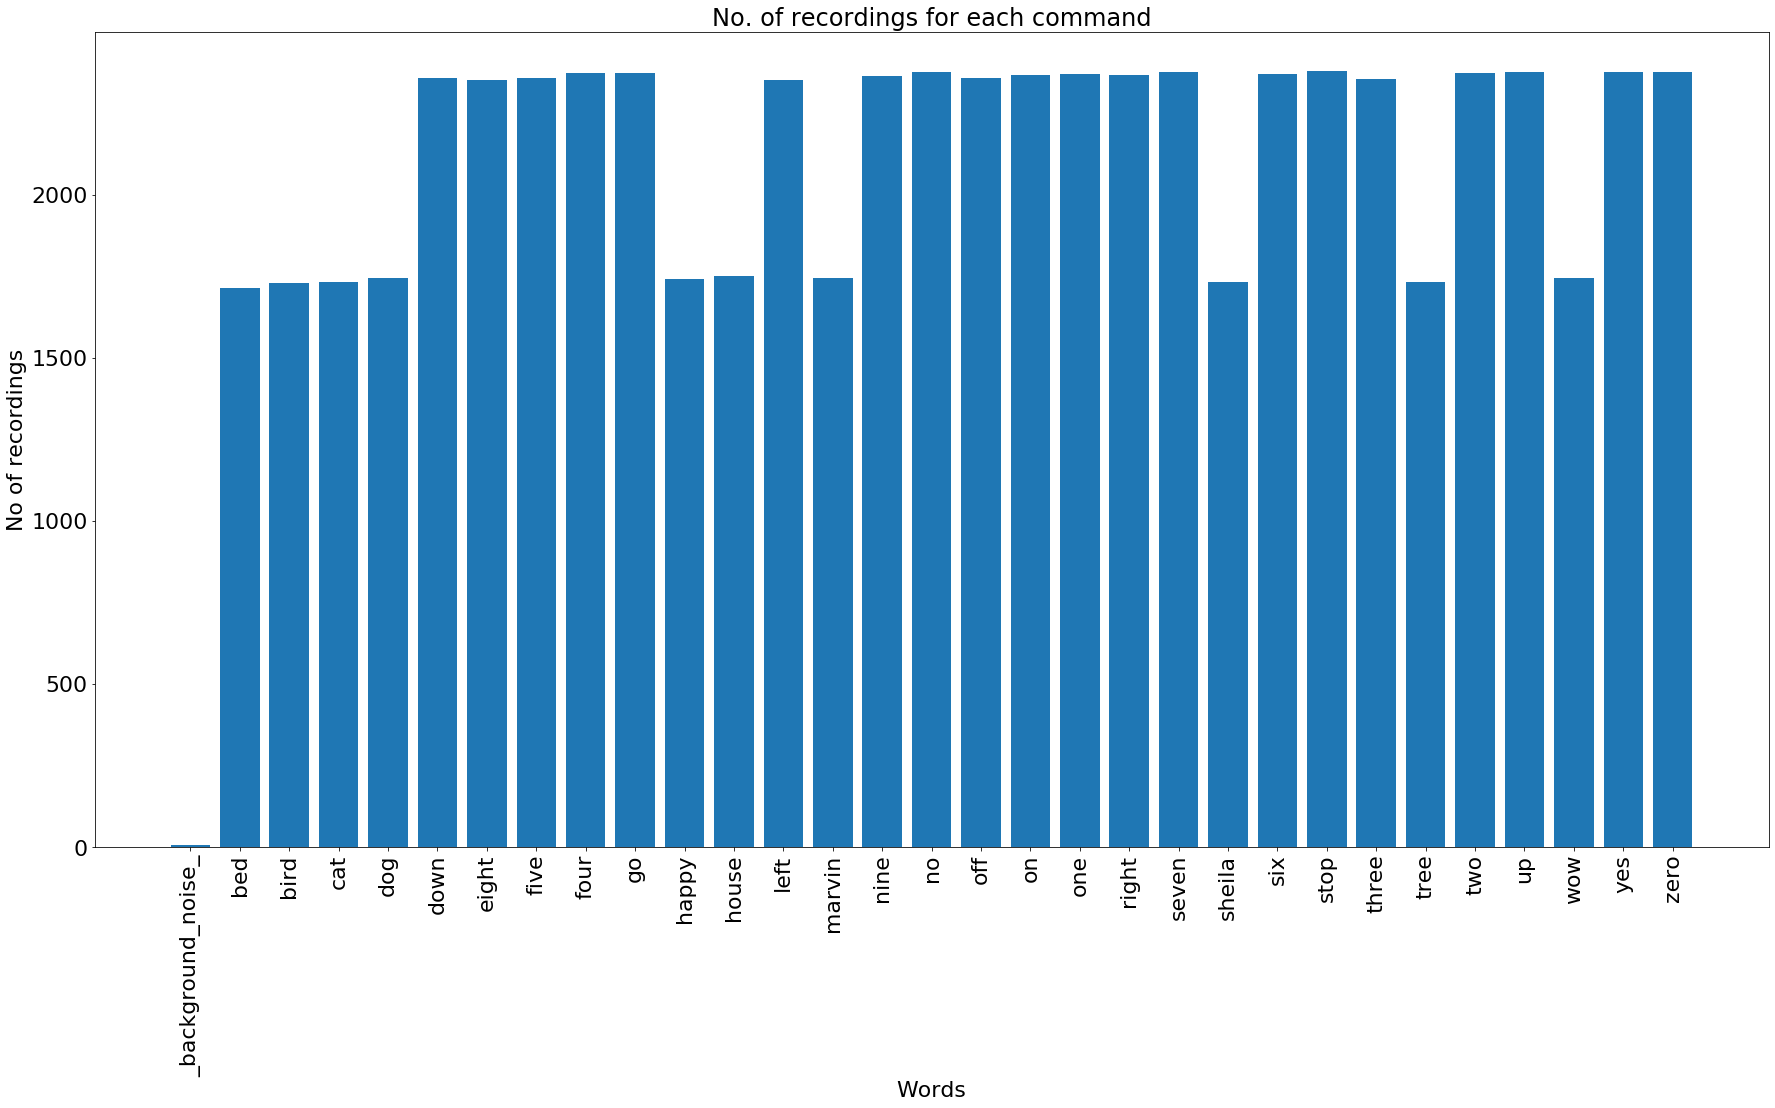

In [2]:
# Number of audio files in each folder

path = '../Data/train/audio/'
folders = os.listdir(path)
folders = [f for f in folders]
folders = sorted(folders)[1:]
files = [len(next(os.walk(path+f))[-1]) for f in folders]
folder_files = dict(zip(folders, files))
sr = 16000


plt.figure(figsize=(30,15))
index = np.arange(len(folder_files.keys()))
plt.bar(folder_files.keys(), folder_files.values())
plt.xlabel('Words', fontsize=22)
plt.ylabel('No of recordings', fontsize=22)
plt.xticks(index, folder_files.keys(), fontsize=22, rotation=90)
plt.yticks(fontsize=22)
plt.title('No. of recordings for each command', fontsize= 24);

In [3]:
Audio(path+'bed/0a7c2a8d_nohash_0.wav')

In [4]:
# Read all the audio files and output them as a dataframe

del folder_files['_background_noise_']


def read_audio_files(path, folder_files, sr):
    df_list = []
    smaller_1, larger_1, records = 0, 0, 0
    
    
    for key in tqdm(folder_files.keys()):
        files = list(os.walk(path+key))[0][-1]
        root = list(os.walk(path+key))[0][0]
        for name in files:
            records += 1
            subdir = os.path.join(root, name)
            audio, sr = librosa.load(subdir, mono=True, duration=60.0, sr=sr)
            
            # resize audio file to make sure its duration is one second - 
            # done by extending its duration by padding it with silence, or by truncating it
            if len(audio) < sr:
                smaller_1 += 1
                audio_temp = np.zeros(sr)
                audio_temp[:audio.shape[0]]=audio
                audio = audio_temp
                del audio_temp
            if len(audio)>sr:
                larger_1 += 1
                audio = audio[:sr] 
                
            # time shift the audio so the highest amplitude be at the center
            sr_half = sr//2
            max_amp_indx = np.argmax(audio)
            time_shift = int(sr_half-max_amp_indx)
            audio = np.roll(audio, time_shift)
                 
            
            df_sample = pd.DataFrame([[audio, key]], columns=['audio', 'label'])
            df_list.append(df_sample)

    df = pd.concat(df_list)
    
    print(f'Total Records = {records}')
    print(f'Records with duration smaller than 1s = {smaller_1}')
    print(f'Records with duration larger than 1s = {larger_1}')
          
    return(df)

        
        
df_audio = read_audio_files(path, folder_files, sr)
df_audio.reset_index(inplace=True, drop=True)

100%|██████████| 30/30 [00:43<00:00,  1.45s/it]


Total Records = 64721
Records with duration smaller than 1s = 6469
Records with duration larger than 1s = 0


In [5]:
# Display head and tail of the dataframe

display(df_audio.head())
display(df_audio.tail())

audio label
0  [-0.0015258789, -0.0015258789, -0.00036621094,...   bed
1  [0.0046081543, 0.0061035156, 0.009277344, 0.01...   bed
2  [0.0010375977, 0.000579834, 0.0014953613, 0.00...   bed
3  [0.00039672852, 0.00015258789, 0.0, -9.1552734...   bed
4  [-6.1035156e-05, -0.00033569336, -0.0002441406...   bed

audio label
64716  [-0.0055236816, -0.0047912598, -0.0021362305, ...  zero
64717  [-0.00012207031, 0.001953125, -0.0010375977, -...  zero
64718  [0.005035400390625, -0.008026123046875, -6.103...  zero
64719  [-0.0009460449, -0.0009460449, -0.0007324219, ...  zero
64720  [0.00039672852, 0.00021362305, -3.0517578e-05,...  zero

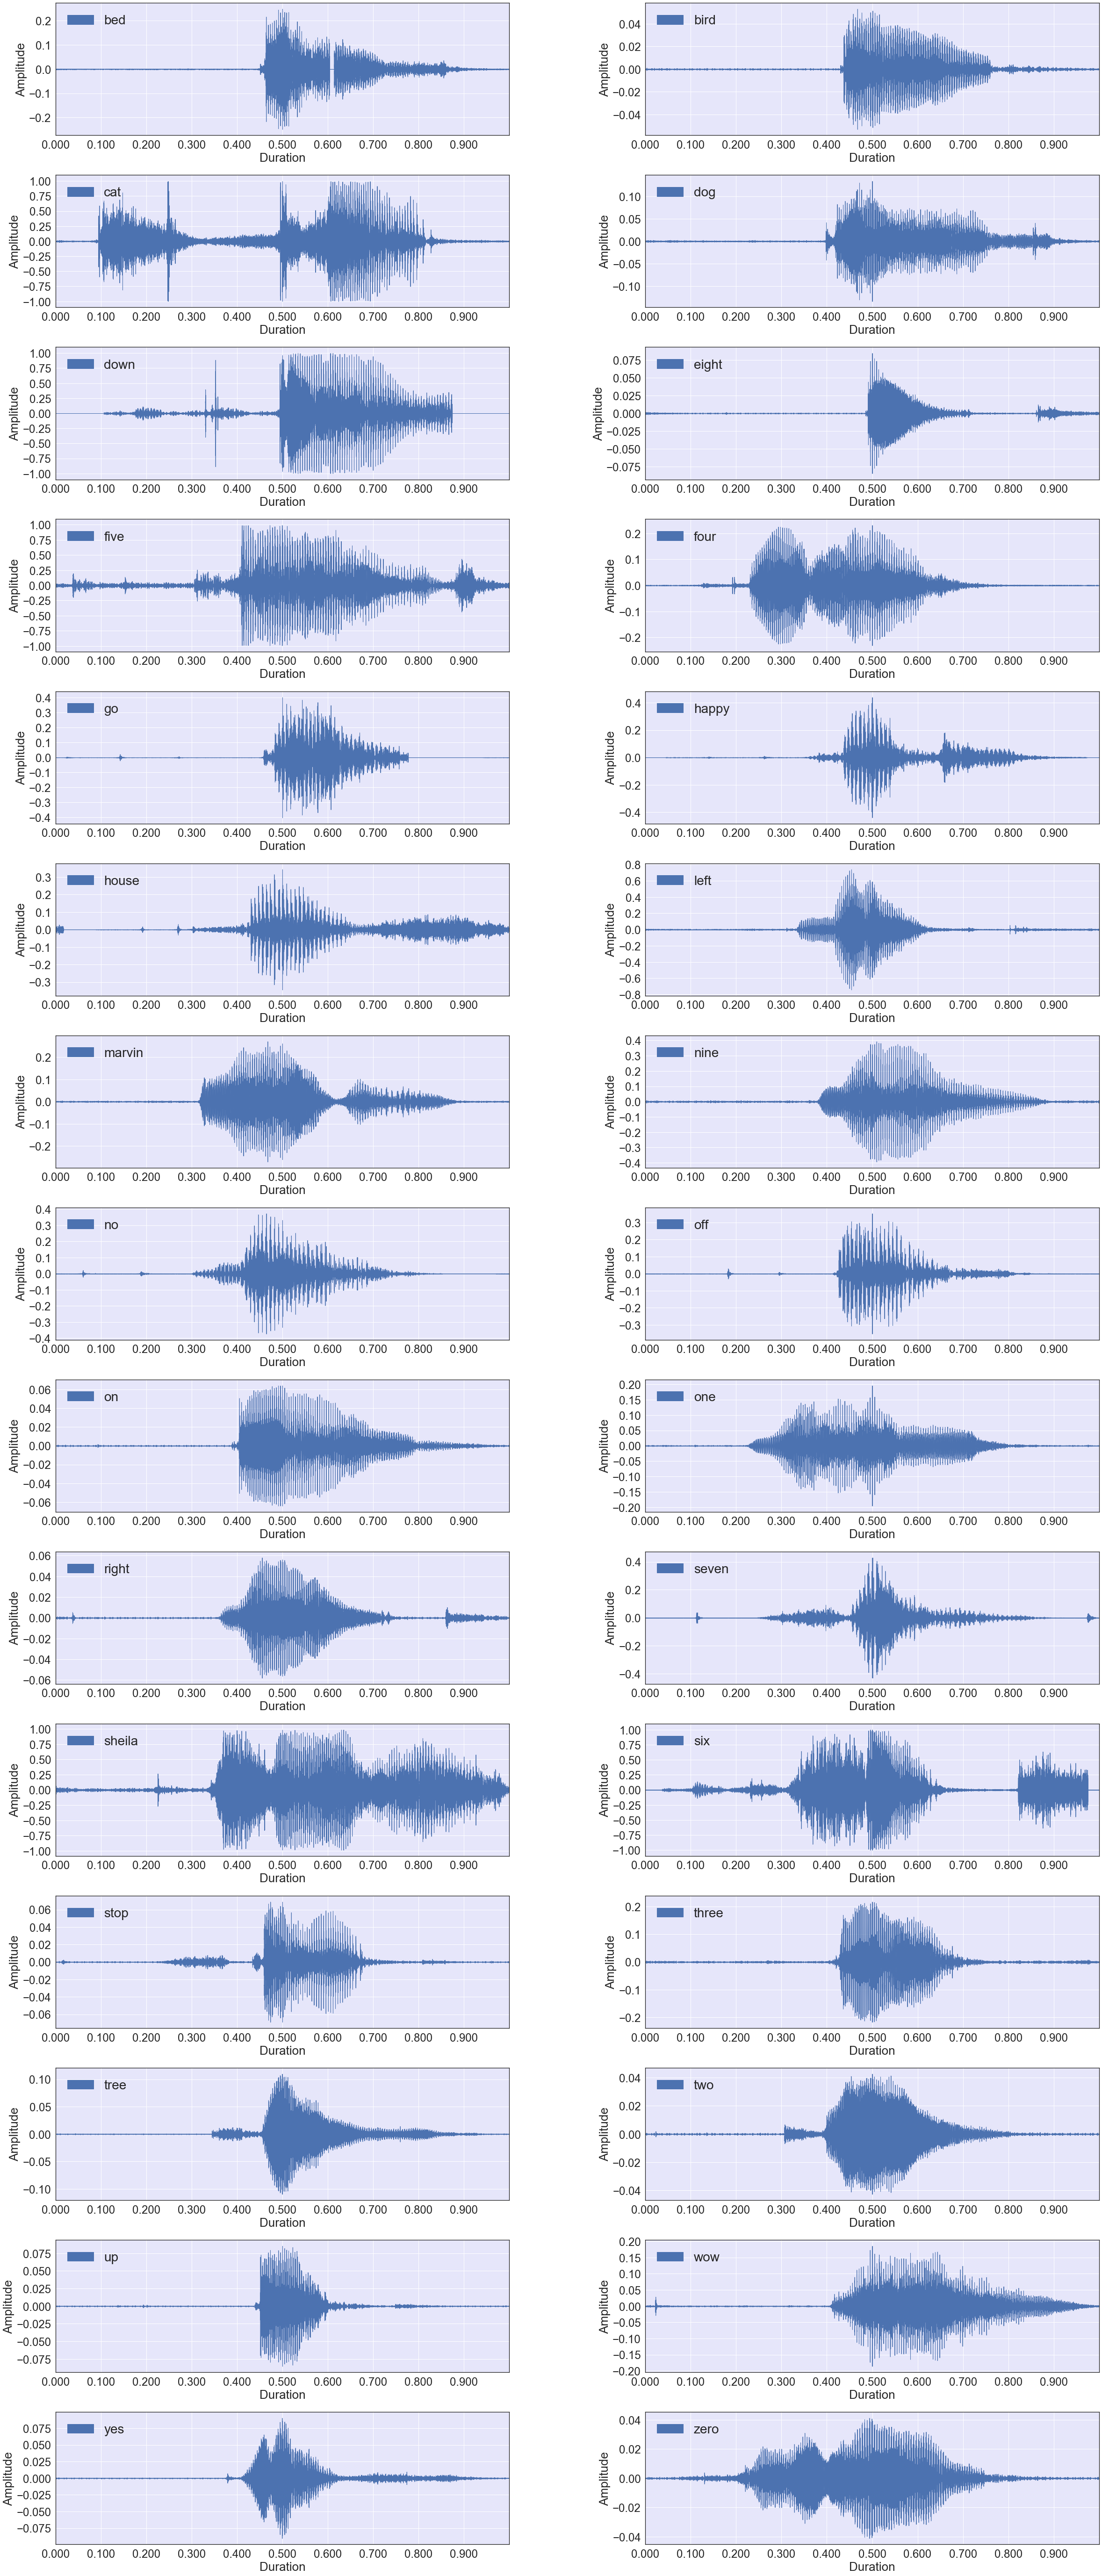

In [6]:
# Plot a sample of raw audio clip from each category

df_first = df_audio.groupby('label').first().reset_index()

fig= plt.subplots(figsize=(40, 100), facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace = .3, wspace=.3)
count = 1
sns.set(rc={'axes.facecolor':'lavender', 'figure.facecolor':'k'})

for i in range(0,30):

    ax = plt.subplot(15,2,count)
    librosa.display.waveplot(df_first.loc[i,'audio'], sr=sr, ax= ax,  label=df_first.loc[i, 'label'])
    
    #ax.set_title(df_first.loc[i, 'label'], fontsize=28)
    ax.set_xlabel('Duration', fontsize=26)
    ax.set_ylabel('Amplitude', fontsize=26)
    ax.legend(fontsize=28, loc='upper left', frameon=False)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)    
    
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_edgecolor('k')
    count+=1  
    

---

## Transform Raw Audio to Mel Spectrogram

The following cells:
- Generate a mel spectrogram for each audio file
- Generate a MFCC for each audio file
- Plot a sample of mel spectrogram and MFCC from each audio category

In [7]:
# Generate mel spectrograms and MFCC coefficients and add them as news columns to the dataframe

def create_mel_spectrogram(df, sr):
    df_copy = df.copy()
    index_list = list(df_copy.index)
    mel_spectrogram = [librosa.feature.melspectrogram(df_copy.loc[indx,'audio'],sr=sr,n_fft=1024, \
                       n_mels=90) for indx in tqdm(index_list)]
    db = [librosa.power_to_db(item, top_db=80, ref=np.max) for item in tqdm(mel_spectrogram)]   
    mfcc = [sklearn.preprocessing.scale((librosa.feature.mfcc(S = item, dct_type=3,  n_mfcc=40)).astype(float), \
                                        axis=1) for item in tqdm(db)]   
    
    mel_df = pd.DataFrame({'mel_spectrogram':db, 'MFCC':mfcc})
    df_copy = pd.concat([df_copy, mel_df], ignore_index = False, axis = 1, join ='inner')
    return(df_copy)
    
    
df_mel = create_mel_spectrogram(df_audio, sr)


100%|██████████| 64721/64721 [00:26<00:00, 2465.18it/s]


In [8]:
df_mel.head()

audio label  \
0  [-0.0015258789, -0.0015258789, -0.00036621094,...   bed   
1  [0.0046081543, 0.0061035156, 0.009277344, 0.01...   bed   
2  [0.0010375977, 0.000579834, 0.0014953613, 0.00...   bed   
3  [0.00039672852, 0.00015258789, 0.0, -9.1552734...   bed   
4  [-6.1035156e-05, -0.00033569336, -0.0002441406...   bed   

                                     mel_spectrogram  \
0  [[-65.57718, -72.400276, -80.0, -79.298195, -7...   
1  [[-56.838924, -60.56248, -63.319786, -65.81624...   
2  [[-67.06361, -64.52769, -59.30992, -65.61657, ...   
3  [[-63.179123, -67.517494, -71.6413, -76.11254,...   
4  [[-80.0, -80.0, -80.0, -80.0, -80.0, -80.0, -8...   

                                                MFCC  
0  [[-0.82226438769556, -0.8704166621477927, -0.9...  
1  [[-0.7933998146275507, -0.7327734523040559, -0...  
2  [[-0.7594528093105377, -0.7336498081845957, -0...  
3  [[-0.7218494715741215, -0.6290570694748141, -0...  
4  [[-0.7167303901116286, -0.7358767548086095, -0...

In [9]:
df_mel.shape

(64721, 4)

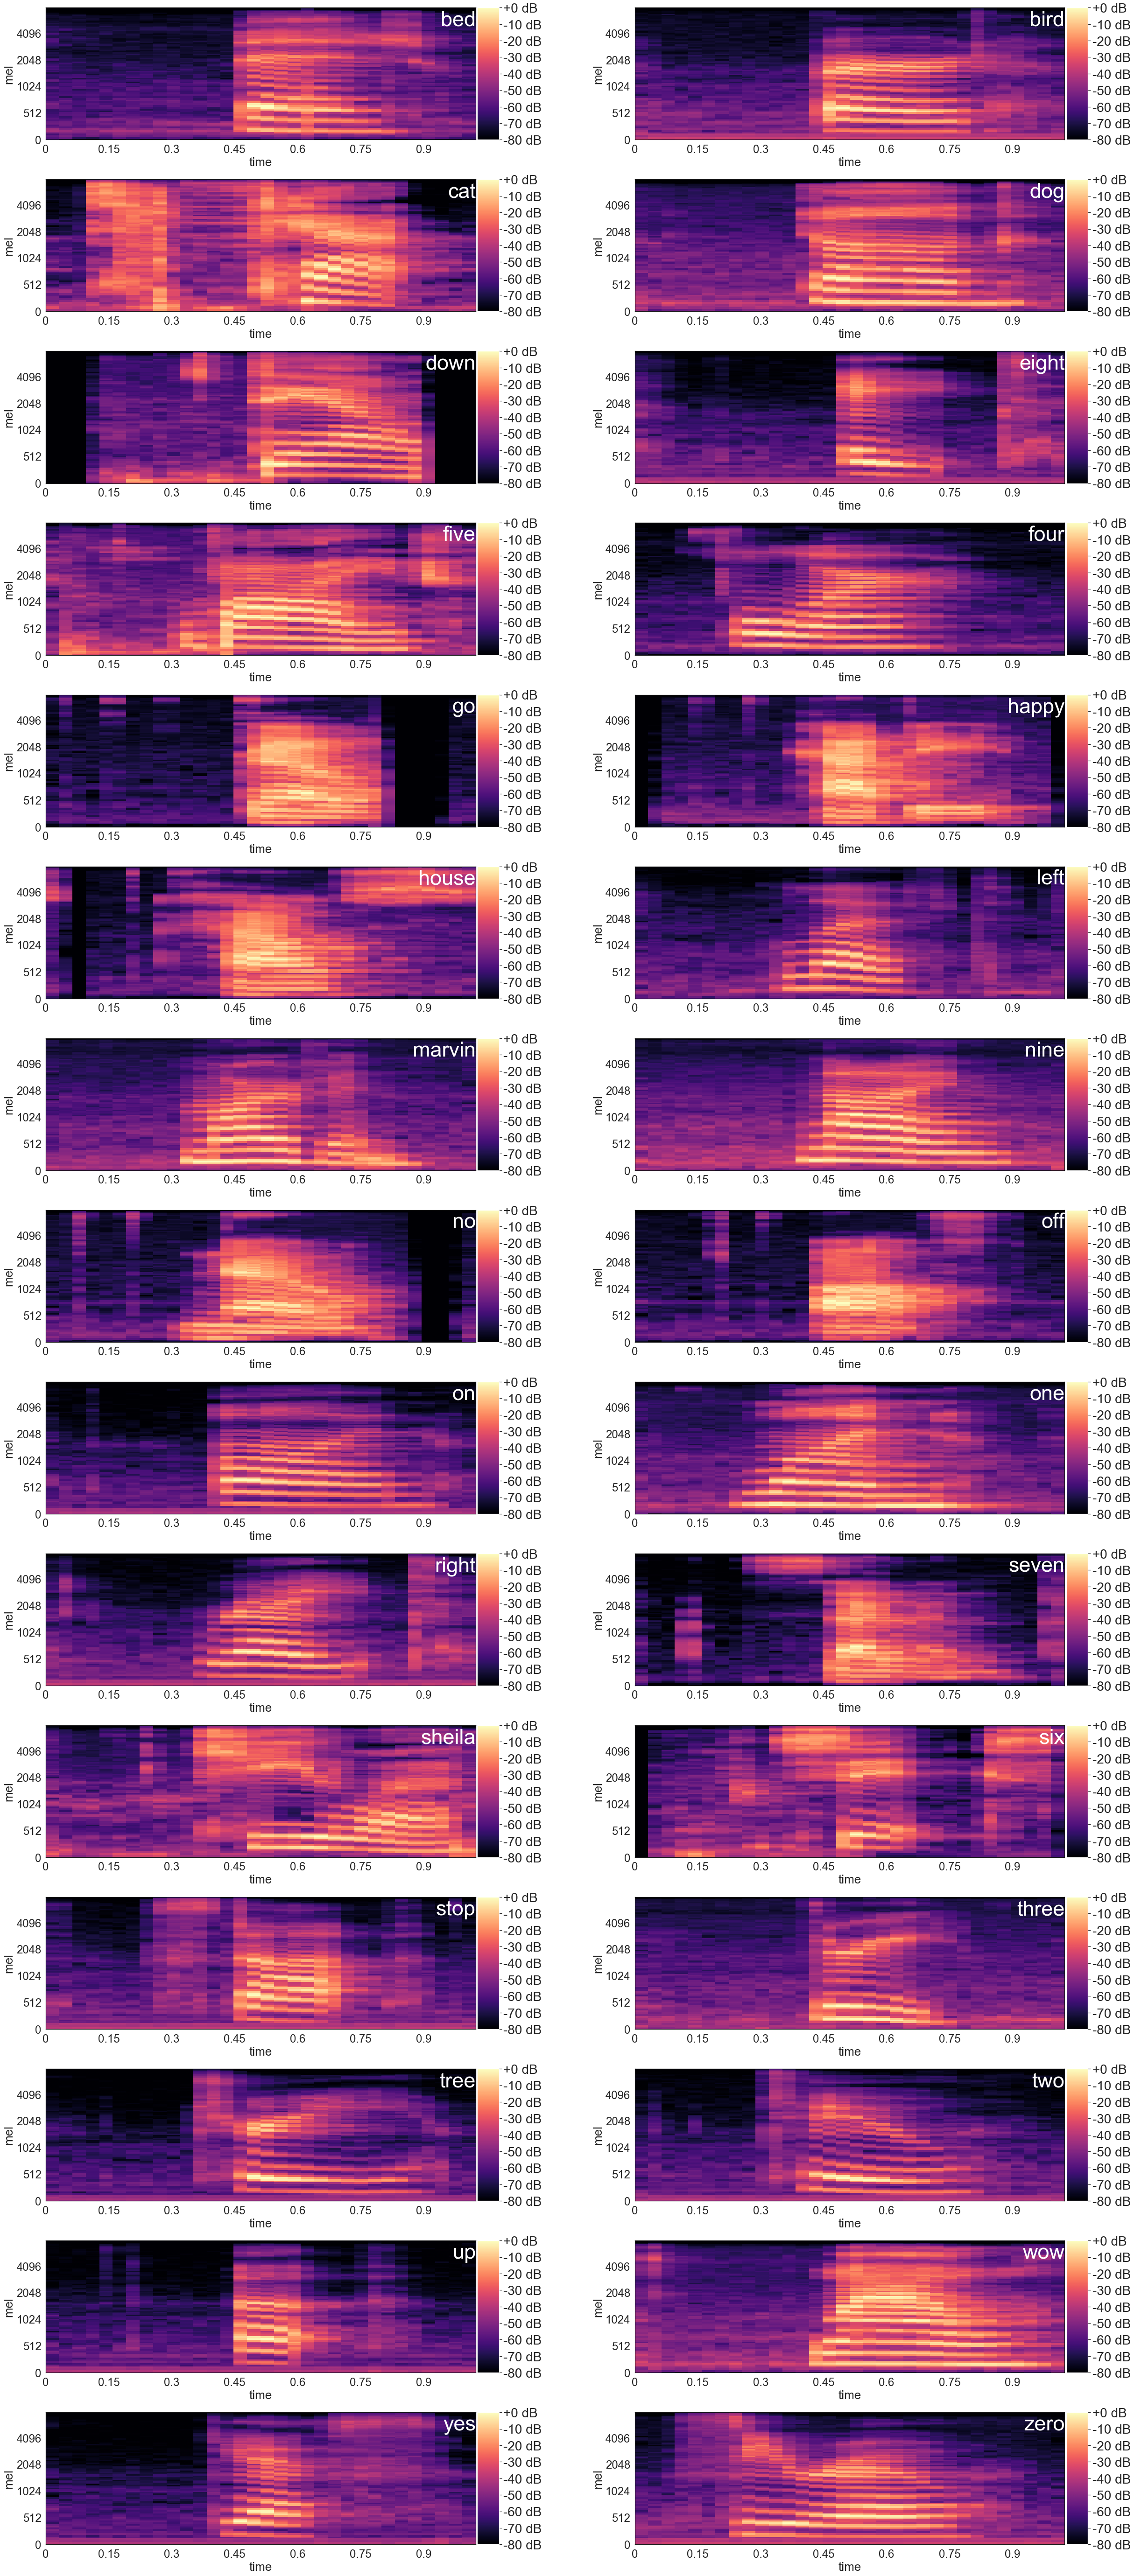

In [10]:
# Plot mel spectrogram

df_first = df_mel.groupby('label').first().reset_index()

fig= plt.subplots(figsize=(40, 100), facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace = .3, wspace=.3)
count = 1
sns.set(rc={'axes.facecolor':'lavender', 'figure.facecolor':'k'})

for i in range(0,30):

    ax = plt.subplot(15,2,count)
    g = librosa.display.specshow(df_first.loc[i, 'mel_spectrogram'], sr=sr, ax=ax, \
                             label=df_first.loc[i, 'label'], x_axis='time', y_axis='mel')
    
    ax.set_xlabel('time', fontsize=26)
    ax.set_ylabel('mel', fontsize=26)
    ax.set_title(df_first.loc[i, 'label'], fontsize=45, color= 'w', loc='right', y=0.9,  pad= -10)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)  
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(g,ax=ax,format='%+2.0f dB', cax=cax)
    cbar.mappable.set_clim(0,-80)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(28)
    
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_edgecolor('k')
    count+=1  
    

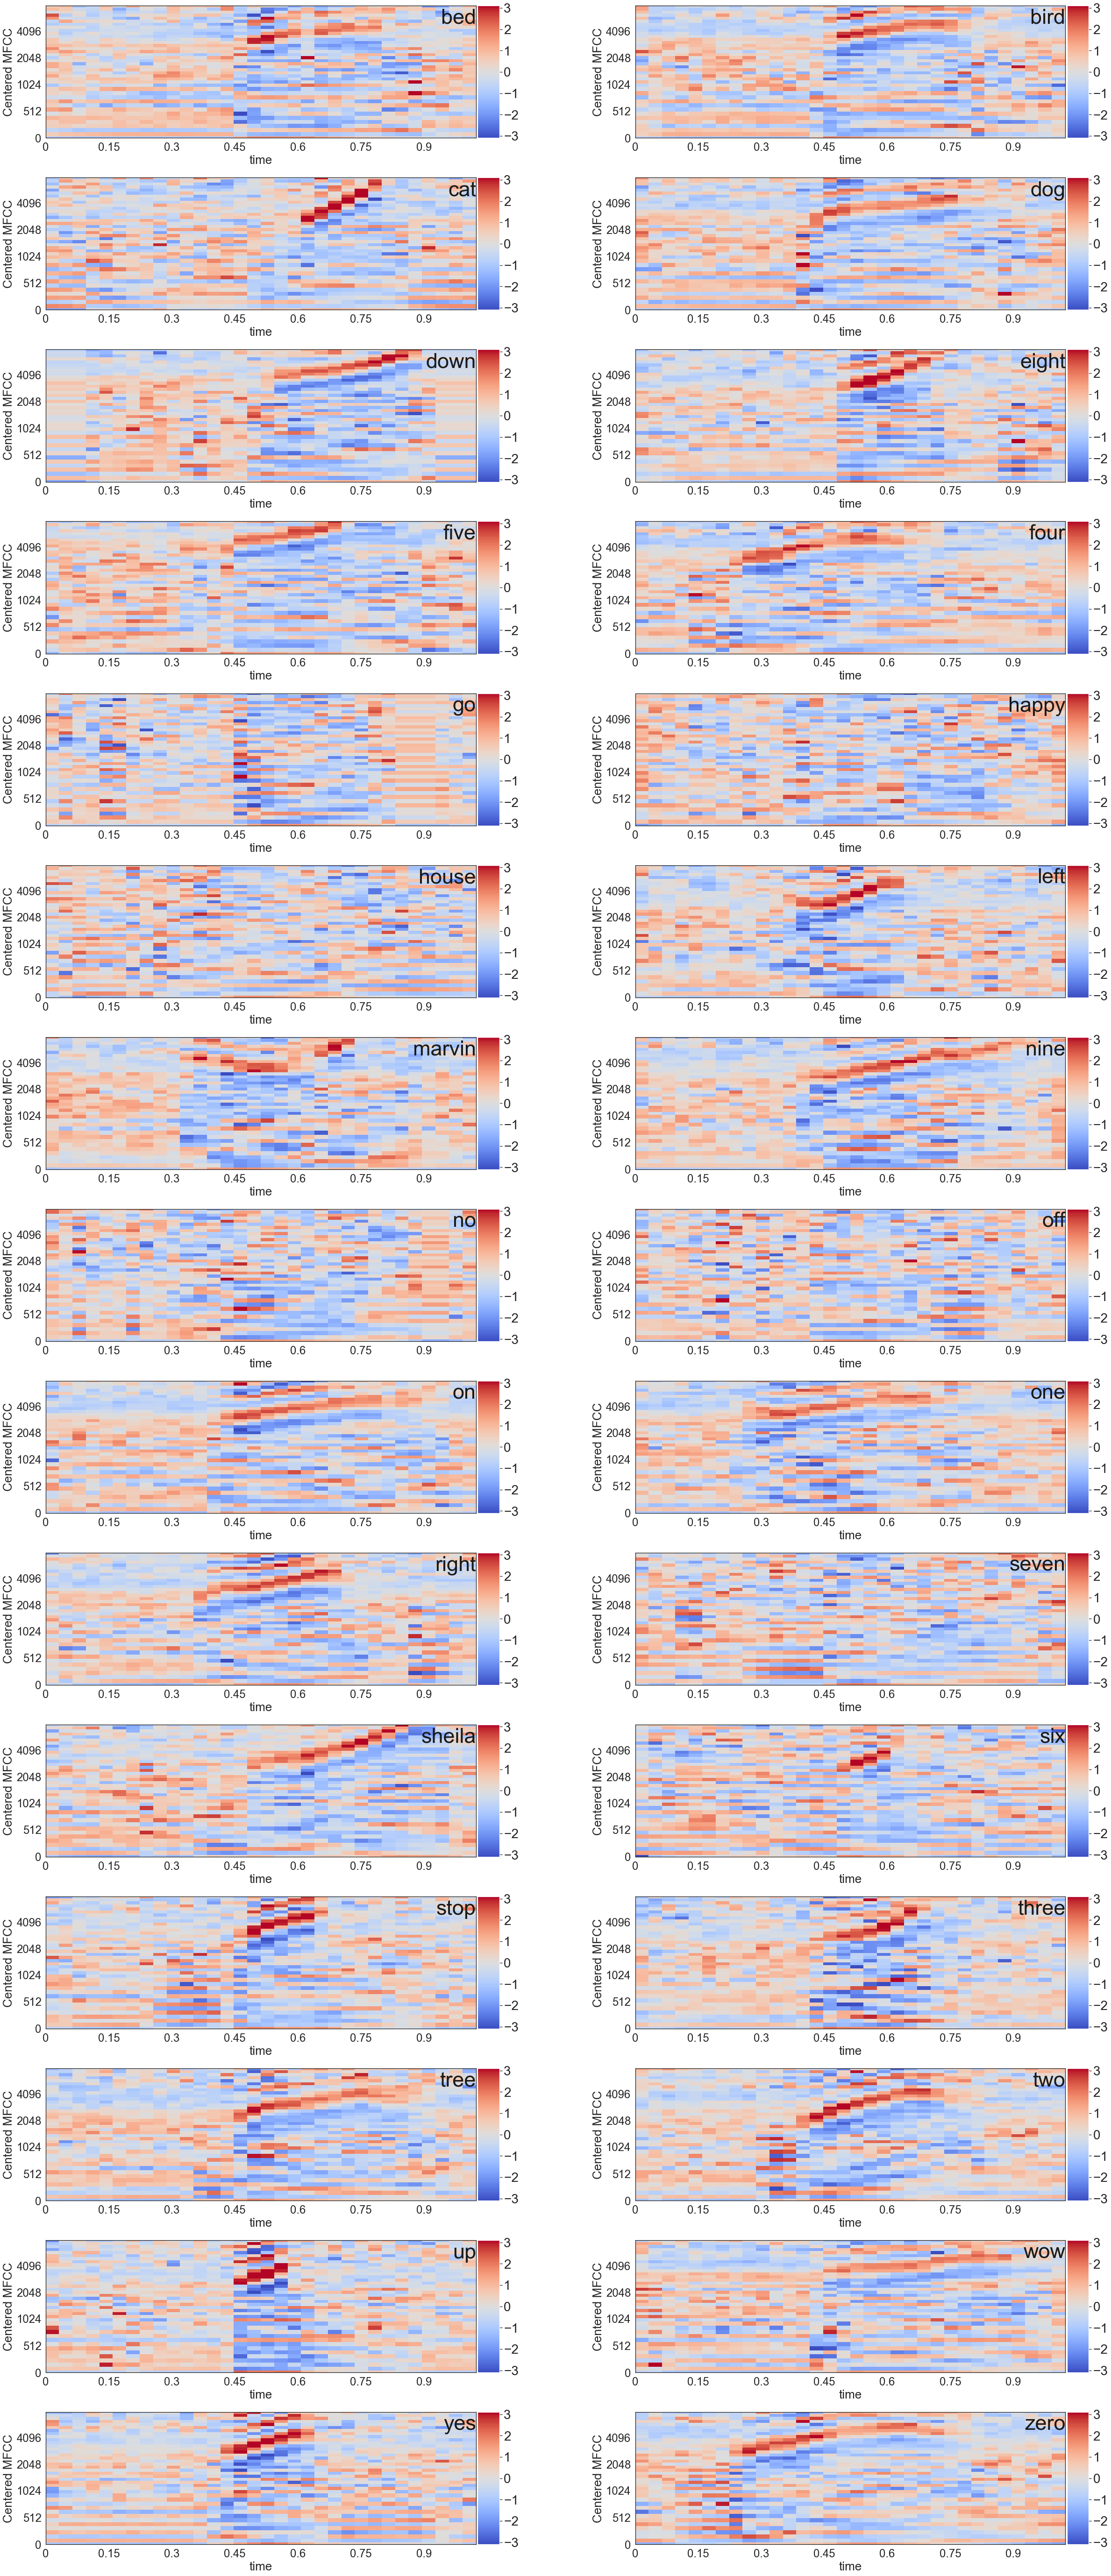

In [11]:
# Plot MFCC

df_first = df_mel.groupby('label').first().reset_index()

fig= plt.subplots(figsize=(40, 100), facecolor='w', edgecolor='k')
plt.subplots_adjust(hspace = .3, wspace=.3)
count = 1
sns.set(rc={'axes.facecolor':'lavender', 'figure.facecolor':'k'})

for i in range(0,30):

    ax = plt.subplot(15,2,count)
    g = librosa.display.specshow(df_first.loc[i, 'MFCC'], sr=sr, ax=ax, \
                             label=df_first.loc[i, 'label'], x_axis='time', y_axis='mel')
    
    ax.set_xlabel('time', fontsize=26)
    ax.set_ylabel('Centered MFCC', fontsize=26)
    ax.set_title(df_first.loc[i, 'label'], fontsize=45, color= 'k', loc='right', y=0.9,  pad= -10)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)  
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(g,ax=ax, cax=cax)
    cbar.mappable.set_clim(-3.1,3.1)
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(28)
    
    for pos in ['top', 'bottom', 'right', 'left']:
        ax.spines[pos].set_edgecolor('k')
    count+=1 

--- 

## Audio Augmentation (Time and Frequency Masking) 

- The following cells mask pixels in mel spectrogram and MFCC columns to reduce overfitting

In [12]:
# Randomly mask out ranges of frequencies and time by adding horizontal and vertical bars 
# Create two new columns for the masked components

def time_freq_mask(df, num_mask_freq, num_mask_time, col_name):
    rng = np.random.default_rng(2022)
    x, y = df.loc[0,col_name].shape
    freq_loc = rng.integers(low=0, high=x, size=num_mask_freq)
    time_loc = rng.integers(low=0, high=y, size=num_mask_time)

    df[str('masked_'+col_name)] = deepcopy(df[col_name].values)
    index_list = list(df.index)
    
    for index in tqdm(index_list):        
        
        mask = df.loc[index,str('masked_'+col_name)]
        temp = pd.DataFrame(deepcopy(df.loc[index,str('masked_'+col_name)]))
        temp.iloc[freq_loc, [i for i in range(y)]] = np.ones(y)*mask.mean() 
        temp = temp.T
        temp.reset_index(inplace=True, drop=True)
        temp.iloc[time_loc, [i for i in range(x)]] = np.ones(x)*mask.mean() 
        temp = temp.T
        temp.reset_index(inplace=True, drop=True)
        df.at[index,str('masked_'+col_name)]=temp.values
                          
    return(df)
                
df_mel = time_freq_mask(df_mel.copy(), 10, 10, 'mel_spectrogram')   
df_mel = time_freq_mask(df_mel.copy(), 5, 5, 'MFCC') 

100%|██████████| 64721/64721 [00:44<00:00, 1467.50it/s]


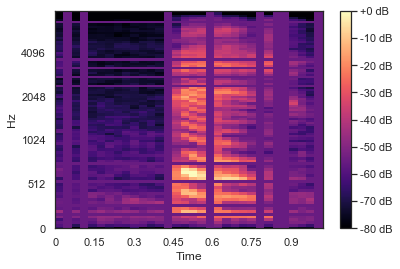

In [13]:
# A sample of masked mel spectrogram

sns.set_style(style='white')
librosa.display.specshow(df_mel.loc[0,'masked_mel_spectrogram'], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

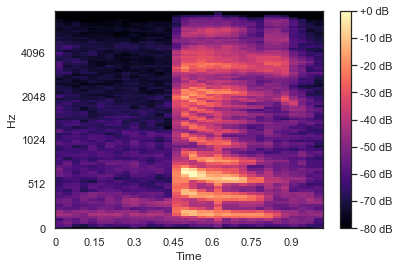

In [14]:
# Above plot without any masking

sns.set_style(style='white')
librosa.display.specshow(df_mel.loc[0,'mel_spectrogram'], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

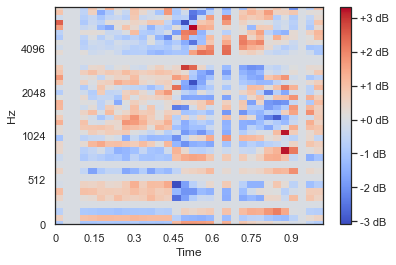

In [15]:
# A sample of masked MFCC

sns.set_style(style='white')
librosa.display.specshow(df_mel.loc[0,'masked_MFCC'], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

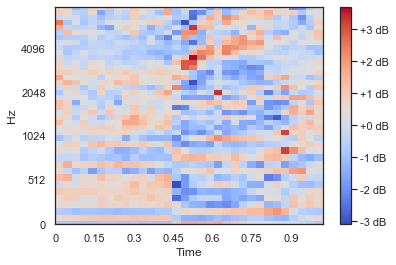

In [16]:
# Above plot without any masking

sns.set_style(style='white')
librosa.display.specshow(df_mel.loc[0,'MFCC'], sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

---

## Modeling

The following cells performs the below procedure for the 4 models:
- Split the data into train and test sets 
- Create a CNN architecture and run the model
- Generate a classification report

The four modeling cases are:
- Mel spectrogram without masking (Case 1)
- Mel spectrogram with masking (Case 2)
- MFCC witout masking (Case 3)
- MFCC with masking (Case 4)

In [17]:
# Split the data into train and test sets

train, test = train_test_split(df_mel, test_size=0.3,random_state=42, stratify=df_mel.loc[:, 'label'])
print(f"Train set dimension: {train.shape}")
print(f"Test set dimension: {test.shape}")

Train set dimension: (45304, 6)
Test set dimension: (19417, 6)


---

### 1. Mel Spectrogram Without Masking

In [18]:
# Generate X_train and X_test

X_train = np.array([row for row in train['mel_spectrogram']])
X_test = np.array([row for row in test['mel_spectrogram']])

tr_1, tr_2, tr_3 = X_train.shape[0], X_train.shape[1], X_train.shape[2]
tst_1, tst_2, tst_3 = X_test.shape[0], X_test.shape[1], X_test.shape[2]

X_train = np.reshape(X_train,(tr_1, tr_2, tr_3 ,1))
X_test = np.reshape(X_test,(tst_1, tst_2, tst_3 ,1))

In [19]:
# Apply one hot-encoding on target variables

lb = LabelEncoder()

y_train = train['label'].values
y_train = lb.fit_transform(y_train)

labels_encoded = lb.classes_
num_labels = len(labels_encoded)
y_train = to_categorical(y_train,num_classes = num_labels)


y_test = test['label'].values
y_test = lb.transform(y_test)
y_test = to_categorical(y_test,num_classes = num_labels)

print(f"Number of unique labels: {num_labels}")

Number of unique labels: 30


In [20]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45304, 90, 32, 1), (45304, 30), (19417, 90, 32, 1), (19417, 30))

In [21]:
# Generate a random seed to make the results of CNN reproducible

from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [22]:
### Instantiate and train a CNN model

cnn = Sequential()

cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 
cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 


cnn.add(Flatten())
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(y_train.shape[1], activation = 'softmax'))
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto')



history = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 1024,
                 epochs = 100,
                 verbose = 1,
                 callbacks=[early_stop])

Epoch 1/100
45/45 [==============================] - 13s 287ms/step - loss: 3.4987 - accuracy: 0.0477 - val_loss: 3.3874 - val_accuracy: 0.0780
Epoch 2/100
45/45 [==============================] - 13s 279ms/step - loss: 2.9066 - accuracy: 0.1960 - val_loss: 2.1830 - val_accuracy: 0.3875
Epoch 3/100
45/45 [==============================] - 12s 278ms/step - loss: 1.8550 - accuracy: 0.4785 - val_loss: 1.6455 - val_accuracy: 0.5451
Epoch 4/100
45/45 [==============================] - 14s 302ms/step - loss: 1.5030 - accuracy: 0.5808 - val_loss: 1.4220 - val_accuracy: 0.6061
Epoch 5/100
45/45 [==============================] - 13s 279ms/step - loss: 1.3252 - accuracy: 0.6340 - val_loss: 1.2865 - val_accuracy: 0.6506
Epoch 6/100
45/45 [==============================] - 13s 278ms/step - loss: 1.2248 - accuracy: 0.6643 - val_loss: 1.2217 - val_accuracy: 0.6692
Epoch 7/100
45/45 [==============================] - 13s 286ms/step - loss: 1.1355 - accuracy: 0.6902 - val_loss: 1.1278 - val_accuracy:

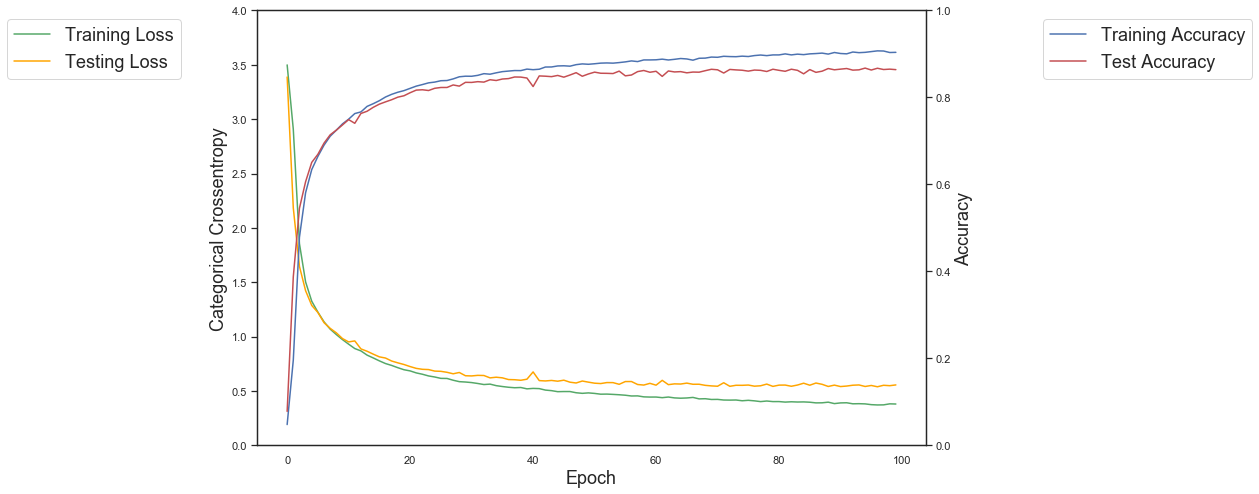

<Figure size 864x576 with 0 Axes>

In [23]:
# Check Model Performance


# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12, 8));


# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8));

# Generate line plot of training, testing loss over epochs.
ax.plot(train_loss, label='Training Loss', color='g');
ax.plot(test_loss, label='Testing Loss', color='orange');

ax.set_xlabel('Epoch', fontsize=18);
ax.set_ylabel('Categorical Crossentropy', fontsize=18);
ax.set_ylim([0, 4]);
ax.set_xticks(epoch_labels, epoch_labels) ;   # ticks, labels
ax.legend(fontsize=18, bbox_to_anchor=(-0.1, 1), loc='upper right', ncol=1);


ax2=ax.twinx();
ax2.plot(history.history['accuracy'], label= 'Training Accuracy', color='b');
ax2.plot(history.history['val_accuracy'], label= 'Test Accuracy', color='r');
ax2.set_ylabel('Accuracy', fontsize=18);
ax2.set_ylim([0, 1]);
ax2.legend(fontsize=18, bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);

In [24]:
# Generate Classification Report

directory ={a:b for a,b in zip(df_mel['label'].unique().tolist(),[i for i in range(num_labels)])}

y_pred = cnn.predict(X_test)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test, axis = 1)
print(classification_report(true_categories, predicted_categories, target_names=list(directory.keys())))

              precision    recall  f1-score   support

         bed       0.91      0.81      0.86       514
        bird       0.88      0.87      0.87       519
         cat       0.88      0.89      0.89       520
         dog       0.89      0.80      0.85       524
        down       0.88      0.80      0.84       708
       eight       0.89      0.92      0.91       706
        five       0.87      0.80      0.83       707
        four       0.89      0.87      0.88       712
          go       0.75      0.79      0.77       712
       happy       0.95      0.94      0.95       523
       house       0.86      0.91      0.88       525
        left       0.86      0.88      0.87       706
      marvin       0.89      0.89      0.89       524
        nine       0.85      0.88      0.86       709
          no       0.77      0.87      0.81       712
         off       0.88      0.81      0.85       707
          on       0.89      0.73      0.80       710
         one       0.85    

---

### 2. Mel Spectrogram With Masking

In [25]:
# Split data into train and test sets
X_train = np.array([row for row in train['masked_mel_spectrogram']])
X_test = np.array([row for row in test['masked_mel_spectrogram']])

tr_1, tr_2, tr_3 = X_train.shape[0], X_train.shape[1], X_train.shape[2]
tst_1, tst_2, tst_3 = X_test.shape[0], X_test.shape[1], X_test.shape[2]

X_train = np.reshape(X_train,(tr_1, tr_2, tr_3 ,1))
X_test = np.reshape(X_test,(tst_1, tst_2, tst_3 ,1))

In [26]:
### Instantiate and train a CNN model

cnn = Sequential()

cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 
cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 


cnn.add(Flatten())
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(y_train.shape[1], activation = 'softmax'))
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto')



history = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 1024,
                 epochs = 100,
                 verbose = 1,
                 callbacks=[early_stop])

Epoch 1/100
45/45 [==============================] - 14s 299ms/step - loss: 4.3869 - accuracy: 0.0333 - val_loss: 3.4854 - val_accuracy: 0.0456
Epoch 2/100
45/45 [==============================] - 13s 286ms/step - loss: 3.4686 - accuracy: 0.0469 - val_loss: 3.4435 - val_accuracy: 0.0519
Epoch 3/100
45/45 [==============================] - 13s 283ms/step - loss: 3.3988 - accuracy: 0.0617 - val_loss: 3.3396 - val_accuracy: 0.0742
Epoch 4/100
45/45 [==============================] - 13s 291ms/step - loss: 3.2407 - accuracy: 0.0865 - val_loss: 3.1228 - val_accuracy: 0.1009
Epoch 5/100
45/45 [==============================] - 13s 296ms/step - loss: 3.0296 - accuracy: 0.1091 - val_loss: 2.9281 - val_accuracy: 0.1293
Epoch 6/100
45/45 [==============================] - 14s 303ms/step - loss: 2.8593 - accuracy: 0.1393 - val_loss: 2.7721 - val_accuracy: 0.1598
Epoch 7/100
45/45 [==============================] - 14s 310ms/step - loss: 2.6561 - accuracy: 0.2016 - val_loss: 2.4983 - val_accuracy:

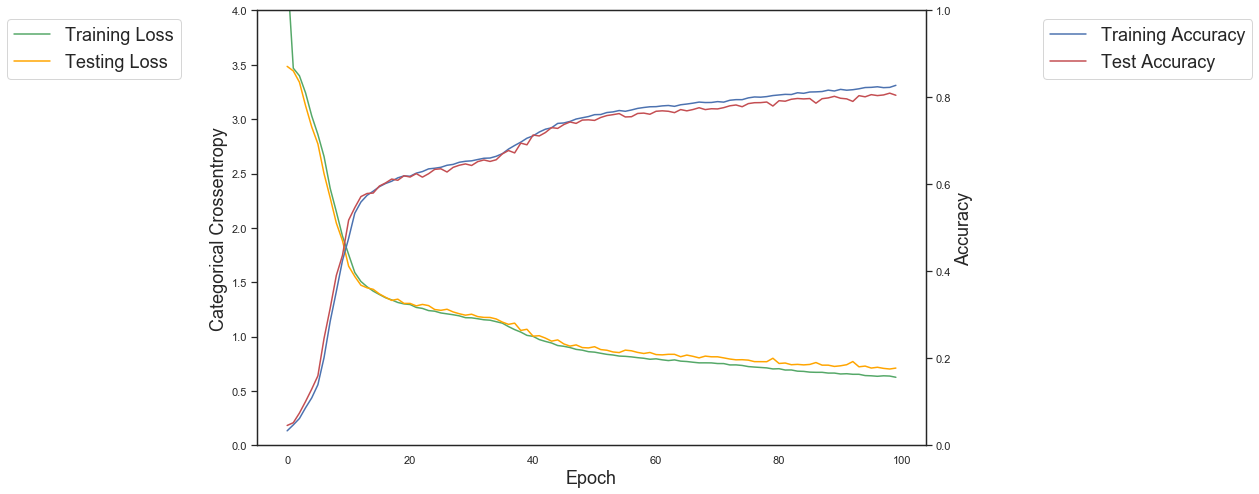

<Figure size 864x576 with 0 Axes>

In [27]:
# Check Model Performance


# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12, 8));


# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8));

# Generate line plot of training, testing loss over epochs.
ax.plot(train_loss, label='Training Loss', color='g');
ax.plot(test_loss, label='Testing Loss', color='orange');

ax.set_xlabel('Epoch', fontsize=18);
ax.set_ylabel('Categorical Crossentropy', fontsize=18);
ax.set_ylim([0, 4]);
ax.set_xticks(epoch_labels, epoch_labels) ;   # ticks, labels
ax.legend(fontsize=18, bbox_to_anchor=(-0.1, 1), loc='upper right', ncol=1);


ax2=ax.twinx();
ax2.plot(history.history['accuracy'], label= 'Training Accuracy', color='b');
ax2.plot(history.history['val_accuracy'], label= 'Test Accuracy', color='r');
ax2.set_ylabel('Accuracy', fontsize=18);
ax2.set_ylim([0, 1]);
ax2.legend(fontsize=18, bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);

In [28]:
# Generate Classification Report

directory ={a:b for a,b in zip(df_mel['label'].unique().tolist(),[i for i in range(num_labels)])}

y_pred = cnn.predict(X_test)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test, axis = 1)
print(classification_report(true_categories, predicted_categories, target_names=list(directory.keys())))

              precision    recall  f1-score   support

         bed       0.78      0.80      0.79       514
        bird       0.81      0.84      0.83       519
         cat       0.82      0.75      0.79       520
         dog       0.71      0.66      0.68       524
        down       0.71      0.79      0.75       708
       eight       0.83      0.86      0.84       706
        five       0.86      0.69      0.77       707
        four       0.83      0.85      0.84       712
          go       0.71      0.72      0.71       712
       happy       0.89      0.88      0.89       523
       house       0.89      0.85      0.87       525
        left       0.86      0.74      0.80       706
      marvin       0.72      0.77      0.74       524
        nine       0.74      0.82      0.78       709
          no       0.68      0.78      0.73       712
         off       0.82      0.81      0.81       707
          on       0.73      0.71      0.72       710
         one       0.78    

---

### 3. MFCC Without Masking

In [29]:
# Split data into train and test sets
X_train = np.array([row for row in train['MFCC']])
X_test = np.array([row for row in test['MFCC']])

tr_1, tr_2, tr_3 = X_train.shape[0], X_train.shape[1], X_train.shape[2]
tst_1, tst_2, tst_3 = X_test.shape[0], X_test.shape[1], X_test.shape[2]

X_train = np.reshape(X_train,(tr_1, tr_2, tr_3 ,1))
X_test = np.reshape(X_test,(tst_1, tst_2, tst_3 ,1))

In [30]:
### Instantiate and train a CNN model

cnn = Sequential()

cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 
cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 


cnn.add(Flatten())
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(y_train.shape[1], activation = 'softmax'))
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto')



history = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 1024,
                 epochs = 100,
                 verbose = 1,
                 callbacks=[early_stop])

Epoch 1/100
45/45 [==============================] - 7s 137ms/step - loss: 3.4844 - accuracy: 0.0482 - val_loss: 3.4389 - val_accuracy: 0.0805
Epoch 2/100
45/45 [==============================] - 6s 136ms/step - loss: 3.2961 - accuracy: 0.1121 - val_loss: 3.0736 - val_accuracy: 0.1624
Epoch 3/100
45/45 [==============================] - 6s 136ms/step - loss: 2.8477 - accuracy: 0.2124 - val_loss: 2.6286 - val_accuracy: 0.2593
Epoch 4/100
45/45 [==============================] - 6s 139ms/step - loss: 2.4831 - accuracy: 0.2988 - val_loss: 2.3488 - val_accuracy: 0.3320
Epoch 5/100
45/45 [==============================] - 6s 140ms/step - loss: 2.2751 - accuracy: 0.3542 - val_loss: 2.2092 - val_accuracy: 0.3721
Epoch 6/100
45/45 [==============================] - 6s 138ms/step - loss: 2.1498 - accuracy: 0.3919 - val_loss: 2.1202 - val_accuracy: 0.3957
Epoch 7/100
45/45 [==============================] - 6s 142ms/step - loss: 2.0505 - accuracy: 0.4218 - val_loss: 2.0031 - val_accuracy: 0.4330

Epoch 58/100
45/45 [==============================] - 6s 141ms/step - loss: 0.9663 - accuracy: 0.7329 - val_loss: 1.0364 - val_accuracy: 0.7116
Epoch 59/100
45/45 [==============================] - 6s 139ms/step - loss: 0.9693 - accuracy: 0.7315 - val_loss: 1.0405 - val_accuracy: 0.7099
Epoch 60/100
45/45 [==============================] - 6s 139ms/step - loss: 0.9557 - accuracy: 0.7354 - val_loss: 1.0310 - val_accuracy: 0.7132
Epoch 61/100
45/45 [==============================] - 6s 140ms/step - loss: 0.9576 - accuracy: 0.7351 - val_loss: 1.0395 - val_accuracy: 0.7117
Epoch 62/100
45/45 [==============================] - 6s 138ms/step - loss: 0.9502 - accuracy: 0.7376 - val_loss: 1.0218 - val_accuracy: 0.7163
Epoch 63/100
45/45 [==============================] - 6s 137ms/step - loss: 0.9477 - accuracy: 0.7386 - val_loss: 1.0273 - val_accuracy: 0.7128
Epoch 64/100
45/45 [==============================] - 6s 137ms/step - loss: 0.9419 - accuracy: 0.7394 - val_loss: 1.0184 - val_accuracy:

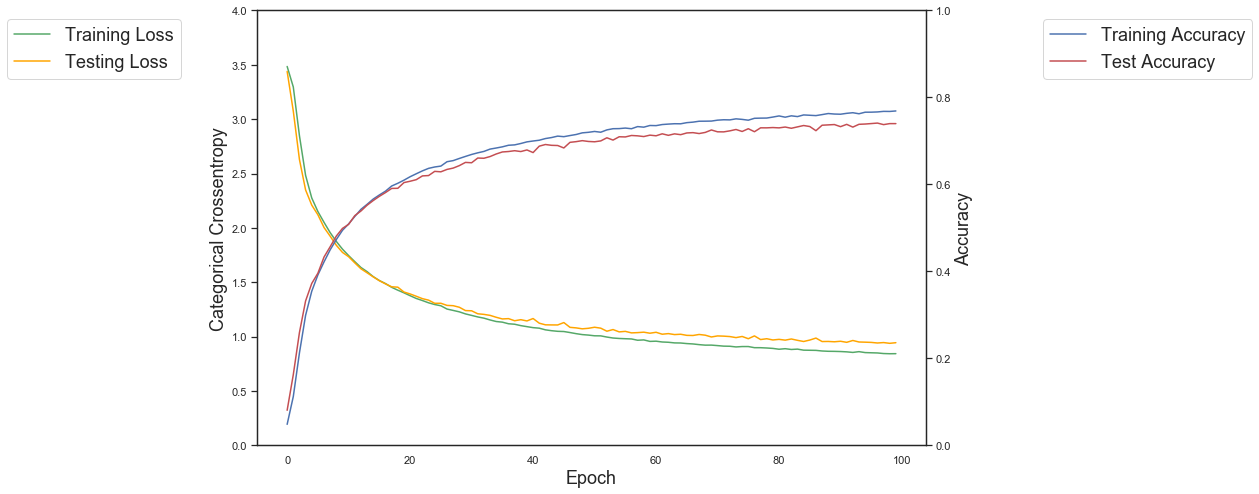

<Figure size 864x576 with 0 Axes>

In [31]:
# Check Model Performance


# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12, 8));


# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8));

# Generate line plot of training, testing loss over epochs.
ax.plot(train_loss, label='Training Loss', color='g');
ax.plot(test_loss, label='Testing Loss', color='orange');

ax.set_xlabel('Epoch', fontsize=18);
ax.set_ylabel('Categorical Crossentropy', fontsize=18);
ax.set_ylim([0, 4]);
ax.set_xticks(epoch_labels, epoch_labels) ;   # ticks, labels
ax.legend(fontsize=18, bbox_to_anchor=(-0.1, 1), loc='upper right', ncol=1);


ax2=ax.twinx();
ax2.plot(history.history['accuracy'], label= 'Training Accuracy', color='b');
ax2.plot(history.history['val_accuracy'], label= 'Test Accuracy', color='r');
ax2.set_ylabel('Accuracy', fontsize=18);
ax2.set_ylim([0, 1]);
ax2.legend(fontsize=18, bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);

In [32]:
# Generate Classification Report

directory ={a:b for a,b in zip(df_mel['label'].unique().tolist(),[i for i in range(num_labels)])}

y_pred = cnn.predict(X_test)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test, axis = 1)
print(classification_report(true_categories, predicted_categories, target_names=list(directory.keys())))

              precision    recall  f1-score   support

         bed       0.69      0.72      0.70       514
        bird       0.76      0.67      0.71       519
         cat       0.77      0.62      0.69       520
         dog       0.77      0.67      0.72       524
        down       0.64      0.69      0.66       708
       eight       0.78      0.73      0.75       706
        five       0.64      0.71      0.67       707
        four       0.83      0.74      0.78       712
          go       0.58      0.64      0.61       712
       happy       0.83      0.85      0.84       523
       house       0.81      0.84      0.83       525
        left       0.80      0.69      0.74       706
      marvin       0.77      0.78      0.77       524
        nine       0.68      0.74      0.70       709
          no       0.72      0.59      0.65       712
         off       0.67      0.73      0.70       707
          on       0.65      0.65      0.65       710
         one       0.78    

---

### 4. MFCC With Masking

In [33]:
# Split data into train and test sets
X_train = np.array([row for row in train['masked_MFCC']])
X_test = np.array([row for row in test['masked_MFCC']])

tr_1, tr_2, tr_3 = X_train.shape[0], X_train.shape[1], X_train.shape[2]
tst_1, tst_2, tst_3 = X_test.shape[0], X_test.shape[1], X_test.shape[2]

X_train = np.reshape(X_train,(tr_1, tr_2, tr_3 ,1))
X_test = np.reshape(X_test,(tst_1, tst_2, tst_3 ,1))

In [34]:
### Instantiate and train a CNN model

cnn = Sequential()

cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 
cnn.add(Conv2D(filters = 5, kernel_size = (4, 4), activation = 'relu', input_shape = (tr_2, tr_3, 1))) 
cnn.add(MaxPooling2D(pool_size = (2, 2))) 


cnn.add(Flatten())
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(30, activation = 'relu', kernel_regularizer=l2(0.001)))
cnn.add(Dense(y_train.shape[1], activation = 'softmax'))
cnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=2, mode='auto')



history = cnn.fit(X_train, y_train, validation_data = (X_test, y_test),
                 batch_size = 1024,
                 epochs = 100,
                 verbose = 1,
                 callbacks=[early_stop])

Epoch 1/100
45/45 [==============================] - 6s 130ms/step - loss: 3.4792 - accuracy: 0.0522 - val_loss: 3.4180 - val_accuracy: 0.0756
Epoch 2/100
45/45 [==============================] - 6s 127ms/step - loss: 3.2434 - accuracy: 0.1056 - val_loss: 3.0244 - val_accuracy: 0.1530
Epoch 3/100
45/45 [==============================] - 6s 131ms/step - loss: 2.8799 - accuracy: 0.1823 - val_loss: 2.7833 - val_accuracy: 0.2109
Epoch 4/100
45/45 [==============================] - 6s 135ms/step - loss: 2.7012 - accuracy: 0.2266 - val_loss: 2.6440 - val_accuracy: 0.2504
Epoch 5/100
45/45 [==============================] - 6s 140ms/step - loss: 2.5781 - accuracy: 0.2638 - val_loss: 2.5401 - val_accuracy: 0.2811
Epoch 6/100
45/45 [==============================] - 6s 141ms/step - loss: 2.4607 - accuracy: 0.2987 - val_loss: 2.4554 - val_accuracy: 0.3078
Epoch 7/100
45/45 [==============================] - 6s 138ms/step - loss: 2.3483 - accuracy: 0.3311 - val_loss: 2.3000 - val_accuracy: 0.3546

Epoch 58/100
45/45 [==============================] - 6s 136ms/step - loss: 1.2081 - accuracy: 0.6723 - val_loss: 1.2484 - val_accuracy: 0.6642
Epoch 59/100
45/45 [==============================] - 6s 135ms/step - loss: 1.1951 - accuracy: 0.6749 - val_loss: 1.2596 - val_accuracy: 0.6580
Epoch 60/100
45/45 [==============================] - 6s 138ms/step - loss: 1.1939 - accuracy: 0.6760 - val_loss: 1.2838 - val_accuracy: 0.6508
Epoch 61/100
45/45 [==============================] - 6s 139ms/step - loss: 1.1931 - accuracy: 0.6753 - val_loss: 1.2425 - val_accuracy: 0.6647
Epoch 62/100
45/45 [==============================] - 6s 139ms/step - loss: 1.1890 - accuracy: 0.6765 - val_loss: 1.2389 - val_accuracy: 0.6651
Epoch 63/100
45/45 [==============================] - 6s 138ms/step - loss: 1.1730 - accuracy: 0.6825 - val_loss: 1.2327 - val_accuracy: 0.6654
Epoch 64/100
45/45 [==============================] - 6s 139ms/step - loss: 1.1697 - accuracy: 0.6831 - val_loss: 1.2446 - val_accuracy:

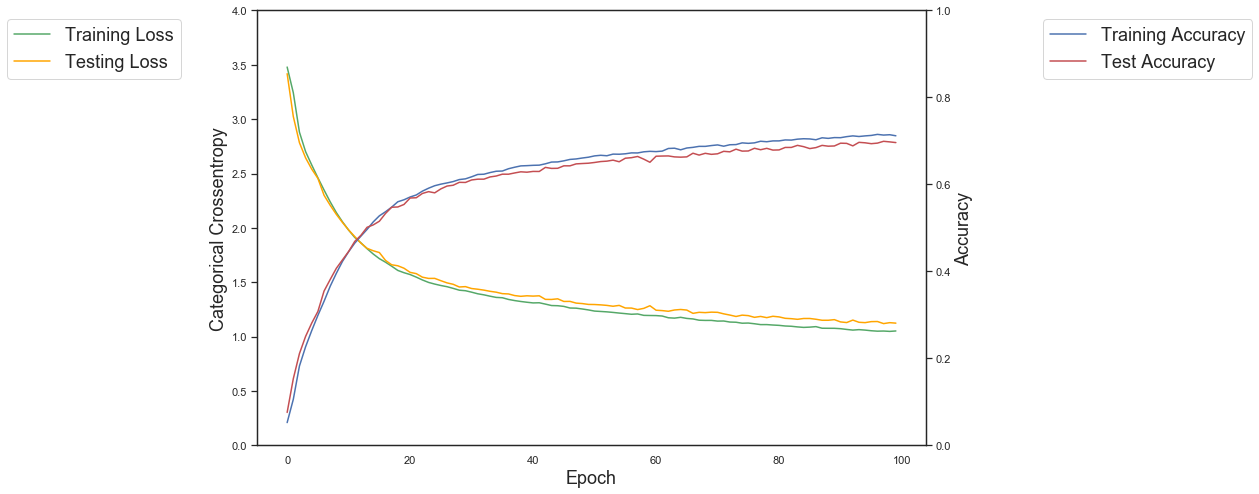

<Figure size 864x576 with 0 Axes>

In [35]:
# Check Model Performance


# create figure and axis objects with subplots()
fig,ax = plt.subplots(figsize=(12, 8));


# Check out our train loss and test loss over epochs.
train_loss = history.history['loss']
test_loss = history.history['val_loss']
epoch_labels = history.epoch

# Set figure size.
plt.figure(figsize=(12, 8));

# Generate line plot of training, testing loss over epochs.
ax.plot(train_loss, label='Training Loss', color='g');
ax.plot(test_loss, label='Testing Loss', color='orange');

ax.set_xlabel('Epoch', fontsize=18);
ax.set_ylabel('Categorical Crossentropy', fontsize=18);
ax.set_ylim([0, 4]);
ax.set_xticks(epoch_labels, epoch_labels) ;   # ticks, labels
ax.legend(fontsize=18, bbox_to_anchor=(-0.1, 1), loc='upper right', ncol=1);


ax2=ax.twinx();
ax2.plot(history.history['accuracy'], label= 'Training Accuracy', color='b');
ax2.plot(history.history['val_accuracy'], label= 'Test Accuracy', color='r');
ax2.set_ylabel('Accuracy', fontsize=18);
ax2.set_ylim([0, 1]);
ax2.legend(fontsize=18, bbox_to_anchor=(1.5, 1), loc='upper right', ncol=1);

In [36]:
# Generate Classification Report

directory ={a:b for a,b in zip(df_mel['label'].unique().tolist(),[i for i in range(num_labels)])}

y_pred = cnn.predict(X_test)
predicted_categories = np.argmax(y_pred, axis = 1)
true_categories = np.argmax(y_test, axis = 1)
print(classification_report(true_categories, predicted_categories, target_names=list(directory.keys())))

              precision    recall  f1-score   support

         bed       0.71      0.70      0.71       514
        bird       0.72      0.72      0.72       519
         cat       0.66      0.67      0.66       520
         dog       0.49      0.63      0.55       524
        down       0.57      0.66      0.61       708
       eight       0.64      0.79      0.71       706
        five       0.63      0.59      0.60       707
        four       0.74      0.70      0.72       712
          go       0.62      0.58      0.60       712
       happy       0.88      0.82      0.85       523
       house       0.82      0.74      0.78       525
        left       0.69      0.68      0.68       706
      marvin       0.83      0.70      0.76       524
        nine       0.66      0.66      0.66       709
          no       0.60      0.63      0.61       712
         off       0.61      0.69      0.65       707
          on       0.59      0.57      0.58       710
         one       0.77    

## Results and Discussion

Data augmentation can be applied not only on the raw data (translate an audio file to a mel spectrogram, but also on the mel spectrogram and MFCC images. Frequency and Time masks are two of the frequent forms of data augmentation on mel spectrogram and MFCC images. Frequency mask randomly blocks out a range of consecutive frequencies by adding horizontal bars on the spectrogram. Time mask is like frequency masks, except that we randomly block out ranges of time from the spectrogram by using vertical bars. These techniques help to reduce overfitting in a model, as shown in the result images. The figures below show the performance of masked and unmasked mel spectrograms for the same neural network structure and with the same number of epochs. As it is shown, applying the time and frequency masks reduce the overfitting but it also slightly drops the value of F-1 score.

## Recommendations

To reduce overfitting in the trained model, it is beneficial to mix in realistic background audio with the audio clips to help the model to cope with noisy environments. It also helps to train the model longer to improve the score, change the number of MFCC coefficients, change the architecture of CNN, or train the model with RNN.